<table>
    <tr>
        <td><img src="./imagenes/Macc.png" width="400"/></td>
        <td>&nbsp;</td>
        <td>
            <h1 style="color:blue;text-align:left">Inteligencia Artificial</h1></td>
        <td>
            <table><tr>
            <tp><p style="font-size:150%;text-align:center">Juegos</p></tp>
            </tr></table>
        </td>
    </tr>
</table>

---

## Objetivo <a class="anchor" id="inicio"></a>

En este notebook veremos el problema de ganar un juego competitivo contra un humano como el desafío que debe superar una máquina y así, al hacerlo, exhibir una dosis de inteligencia. El desafío es que el entorno es dinámico, toda vez que éste cambiará de acuerdo a las acciones del contrincante. 

Estudiaremos algunas estrategias para la búsqueda de la mejor jugada en juegos de dos jugadores. Estos escenarios, a pesar de ser dinámicos, todavía son muy convenientes, toda vez que corresponden a entornos completamente observables, discretos y conocidos. 

También veremos cómo hacer más eficiente el tiempo de búsqueda, al podar el árbol de confrontación. Haremos una poda a lo ancho mediante el algoritmo alfa-beta y una poda a lo alto mediante un cutoff y el uso de funciones de evaluación, las cuales usan información de expertos para evaluar los tableros.

En este notebook también estudiaremos cómo evaluar un tablero  cuando no contamos con suficiente conocimiento experto y no sabemos cómo definir una función de evaluación adecuada. La estrategia que estudiaremos se llama la búsqueda en árboles Monte Carlo (Monte Carlo Tree Search). 

Adaptado de (Russell & Norvig, 2020), secciones 5.1, 5.2, 5.3 y 5.4.

[Ir a ejercicio 1](#ej1)

## Dependencias

Al iniciar el notebook o reiniciar el kerner se pueden cargar todas las dependencias de este notebook corriendo las siguientes celdas. Este también es el lugar para instalar las dependencias que podrían hacer falta.

In [1]:
#!pip install -r requirements.txt

**De Python:**

In [1]:
from random import choice
import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import sleep
import pandas as pd
import seaborn as sns
import numpy as np
from copy import deepcopy
from itertools import product
import warnings
warnings.filterwarnings('ignore')

**Del notebook:**

In [2]:
from juegos import Triqui, ReyTorreRey
from tiempos import compara_funciones
from utils import *
from agents import *

%reload_ext autoreload
%autoreload 2

## Secciones

Desarrollaremos la explicación de la siguiente manera:

1. [Definición formal del problema de confrontación](#triqui).
2. [Algoritmo minimax](#minimax).
    - [Árbol de confrontación](#arbol)
    - [Pseudocódigo](#codigo)
    - [Engine](#engine)
3. [Algoritmo de poda alfa-beta](#alfa-beta).
    - [Pseudocódigo](#codigo-a-b)
    - [Engine](#engine-a-b)
4. [Funciones de evaluación](#feval)
5. [Monte Carlo Tree Search](#mcts)
    - [Simulación de juego](#sim)
    - [Selección de nodos](#seleccion).
    - [Expansión del árbol](#expansion).
    - [Back-up del valor](#back-up)


## Definición formal del problema de confrontación en juegos competitivos <a class="anchor" id="triqui"></a>

([Volver al inicio](#inicio))

Mostraremos a continuación la **definición formal de un juego competitivo**. Para ello, nos valdremos de un ejemplo. Consideraremos el juego de tres en línea (o triqui), que todos conocemos desde niños. La definición formal se hace con base en las siguientes características:

* **estado_inicial:** Situación del entorno desde el cual comienza el juego. En el caso del triqui, el estado inicial es el tablero $3\times 3$ vacío.

* **player(s):** Define cuál jugador tiene el turno en el estado `s`, el cual puede ser `O` o `X`.

* **acciones(s):** Descripción de las posibles acciones del jugador dado por `a_jugar(s)` en el estado `s`. En este caso, poner o bien una `O` o bien una `X` en una casilla vacía.

* **resultado(s, a):** Descripción del entorno que resulta de la ejecución de la acción `a` por el jugador dado por `a_jugar(s)` en el estado `s`. 

* **es_terminal(s):** Permite determinar si el juego se termina cuando se obtiene el estado `s`. 

* **utilidad(s, j):** Función definida sólo para aquellos estados `s` en los cuales el juego se termina. Esta función establece la utilidad en el estado `s` que se obtiene después de haber jugado el jugador `j`. En nuestro caso del triqui, asumiremos que si el ganador es $O$, la utilidad es -1; si el ganador es $X$, la utilidad es 1; y en caso de empate la utilidad es 0.

Asumiremos la siguiente manera de referirnos a las casillas del tablero:

<img src="imagenes/triqui.png" width="300px">

La siguiente es una posible implementación en Python del ambiente de tarea para el triqui:

Este es el tablero con una X en (1, 0)


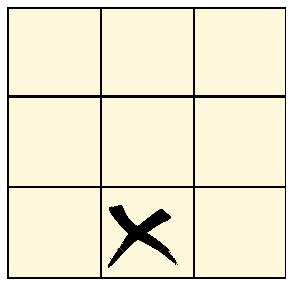

Juego terminado?: False
Le corresponde el turno a: O
Utilidad: None


In [4]:
tri = Triqui()
s = tri.estado_inicial
a = choice(tri.acciones(s))
print("Este es el tablero con una X en", a)
s1 = tri.resultado(s, a)
tri.render(s1)
print("Juego terminado?:", tri.es_terminal(s1)) # Debe ser False
print("Le corresponde el turno a:", 'O' if tri.player(s1) == 1 else 'X') # Debe ser O
print("Utilidad:", tri.utilidad(s1, tri.player(s1))) # Debe ser None

# Algoritmo minimax <a class="anchor" id="minimax"></a>

([Volver al inicio](#inicio))

Debemos ahora definir un programa para el agente que juega triqui. Este programa debe consistir, de manera general, en una función que percibe un tablero de triqui y devuelve una acción. Más concretamente, el agente recibe un estado `s` y devuelve una jugada, en forma de un índice `(x,y)` que representa la casilla en la cual ha de ponerse el símbolo correspondiente (o bien $O$ o bien $X$). 

El algoritmo que utilizaremos para encontrar la mejor jugada se llama *minimax*. Este nombre es muy acertado, toda vez que evoca simultáneamente la confrontación entre los jugadores así como la manera como se representa dicha confrontación. Esto es, un jugador buscará el mínimo y el otro el máximo de la utilidad. Esta es la razón por la cual se definió la función de utilidad de tal manera que un estado en el que gane $O$ valga -1 y uno en que gane $X$ valga 1. El primer jugador será MIN y el segundo MAX.

## Árbol de confrontación <a class="anchor" id="arbol"></a>

([Volver a minimax](#minimax))

Dado un estado `s`, se define un árbol de confrontación para `s` de la siguiente manera. Se consideran para el jugador que tiene el turno, digamos MAX, todas las acciones `i` que se pueden aplicar, y para cada una de ellas se encuentra el correspondiente estado `s`$_i$. Luego, para cada uno de estos, se consideran para MIN todas las acciones que se pueden aplicar y se encuentran los correspondientes estados. Esta iteración se repite hasta llegar a los estados en los cuales el juego se termina. En estos estados podemos hallar la utilidad y aquí comenzamos a encontrar los valores minimax de todo el arbol. Es decir, hemos construido el árbol de arriba hacia abajo (de la raíz hacia las hojas) siguiendo las acciones posibles. Ahora encontraremos los valores minimax para cada estado yendo de abajo hacia arriba (de las hojas hacia la raíz). Así pues, obtenemos los valores minimax a partir de la utilidad de los estados terminales, por ejemplo:

<img src="imagenes/ejemplo1.png" width="250px">

Suponiendo que estos estados provienen de una acción de las $X$, ellos provienen de estados más arriba en el árbol, como por ejemplo:

<img src="imagenes/ejemplo2.png" width="250px">

Como la acción en dichos estados es de $X$, que es MAX, entonces el valor minimax se obtiene al encontrar el máximo dentro de todas las opciones posibles. Esto no es interesante en este caso, pues sólo hay una acción posible para $X$, el cual determina el valor minimax para dicho estado.

El siguiente nivel hacia arriba es más interesante, pues $O$ (es decir, MIN), tiene varias opciones:

<img src="imagenes/ejemplo3.png" width="260px">

En este caso $O$ tiene dos opciones, cada una reportando un valor minimax. El valor que MIN escogerá es el mínimo entre los dos valores, es decir, 0. Este es el valor minimax de este estado.

Ahora consideremos un nivel más arriba. Juega $X$ (es decir, MAX):

<img src="imagenes/ejemplo4.png" width="550px">

En el estado que vemos más arriba, el jugador de las $X$ es quien tiene el turno, es decir, juega MAX. Él debe seleccionar la opción que le reporte el máximo de los valores minimax de sus hijos. En este caso, debe seleccionar la única opción con valor 0. Observe que si $X$ seleccionara cualquier otra opción (las cuales tienen valor $-1$), entonces MIN ganaría (suponiendo que MIN juega de la mejor manera posible). Esto es, MAX busca la acción cuyo resultado tenga el mayor valor minimax, por lo que decide poner una $X$ en la casilla de abajo a la izquierda para bloquear el triqui de $O$. Esta acción resulta en el estado de la derecha. 


## Pseudo código para minimax <a class="anchor" id="codigo"></a>

([Volver a minimax](#minimax))

El siguiente es el pseudo código del algoritmo de decisión minimax, el cual genera, mediante una metodología depth-first, el árbol de confrontación para un estado `s` en el cual le corresponde el turno a MAX:

<img src="imagenes/busqueda-minimax.png" width="500px">


**Nota:** Hay dos errores en el pseudocódigo:

1. La función Minimax-search no necesita la primera línea para guardar la información del agente al que le corresponde el turno.
2. Las funciones Max-value y Min-value sí necesitan incluir una primera línea con la información del agente al que le corresponde el turno.

<a class="anchor" id="ej1"></a>**Ejercicio 1:** 

([Próximo ejercicio](#ej2))

Implemente el anterior pseudocódigo para la función `minimax_search`. Compruebe que la respuesta de $X$ para el siguiente tablero debe ser bloquear el triqui de $O$ en la casilla $(0,0)$.

In [276]:
import numpy as np

def minimax_search(juego, estado):
    pass  

def max_value(juego, estado):
    pass

def min_value(juego, estado):
    pass

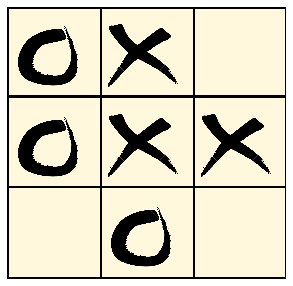

Computador juega en: (0, 0)


In [6]:
tri = Triqui()
s = tri.estado_inicial
s = tri.resultado(s, (1,1)) # Juega X
s = tri.resultado(s, (0,2)) # Juega O
s = tri.resultado(s, (1,2)) # Juega X
s = tri.resultado(s, (1,0)) # Juega O
s = tri.resultado(s, (2,1)) # Juega X
s = tri.resultado(s, (0,1)) # Juega O
tri.render(s)
print("Computador juega en:", minimax_search(tri, s)) 
# La respuesta debe ser (0, 0)

**Respuesta:**

In [5]:
import numpy as np

def minimax_search(juego, estado):
    jugador = juego.player(estado)
    valor, accion = max_value(juego, estado)
    return accion  

def max_value(juego, estado):
    if juego.es_terminal(estado):
        jugador = juego.player(estado)
        return juego.utilidad(estado, jugador), None
    v = -np.infty
    for a in juego.acciones(estado):
        v2, a2 = min_value(juego, juego.resultado(estado, a))
        if v2 > v:
            v = v2
            accion = a
    return v, accion

def min_value(juego, estado):
    if juego.es_terminal(estado):
        jugador = juego.player(estado)
        return juego.utilidad(estado, jugador), None
    v = np.infty
    for a in juego.acciones(estado):
        v2, a2 = max_value(juego, juego.resultado(estado, a))
        if v2 < v:
            v = v2
            accion = a
    return v, accion

---

<a class="anchor" id="ej2"></a>**Ejercicio 2:** 

([Anterior ejercicio](#ej1)) ([Próximo ejercicio](#ej3))

Compruebe la correctitud de su algoritmo mediante los siguientes tableros de prueba:

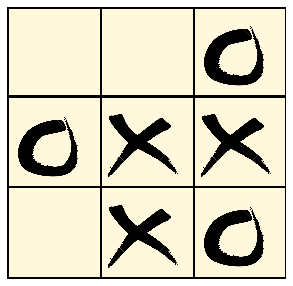

Computador juega en: (1, 2)


In [7]:
# Primer tablero de prueba
s1 = tri.resultado(tri.estado_inicial, (1,1))  # Juega X
s1 = tri.resultado(s1, (0,1)) # Juega O
s1 = tri.resultado(s1, (2,1)) # Juega X
s1 = tri.resultado(s1, (2,2)) # Juega O
s1 = tri.resultado(s1, (1,0)) # Juega X
s1 = tri.resultado(s1, (2,0)) # Juega O
tri.render(s1)
print("Computador juega en:", minimax_search(tri, s1)) 
# La respuesta debe ser (1, 2)

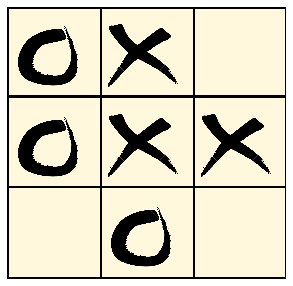

Computador juega en: (0, 0)


In [8]:
# Segundo tablero de prueba
s1 = tri.resultado(tri.estado_inicial, (2,1)) # Juega X
s1 = tri.resultado(s1, (0,1)) # Juega O
s1 = tri.resultado(s1, (1,2)) # Juega X
s1 = tri.resultado(s1, (1,0)) # Juega O
s1 = tri.resultado(s1, (1,1)) # Juega X
s1 = tri.resultado(s1, (0,2)) # Juega O
tri.render(s1)
print("Computador juega en:", minimax_search(tri, s1)) 
# La respuesta debe ser (0, 0)

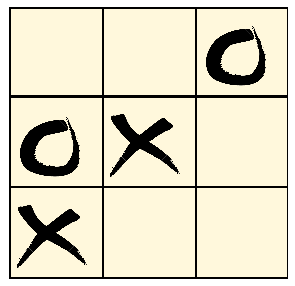

Computador juega en: (1, 0)


In [9]:
# Tercer tablero de prueba
s1 = tri.resultado(tri.estado_inicial, (1,1)) # Juega X
s1 = tri.resultado(s1, (0,1)) # Juega O
s1 = tri.resultado(s1, (0,0)) # Juega X
s1 = tri.resultado(s1, (2,2)) # Juega O
tri.render(s1)
print("Computador juega en:", minimax_search(tri, s1)) 
# La respuesta debe ser (1, 0) o (2, 0)

---

Observe que la clase `Triqui` tiene el método `player`, el cual recibe un estado `s` y devuelve el jugador al que le corresponde el turno en `s`. La codificación es que si `player(s)` es 1, le corresponde el turno a $O$; y si es 2, le corresponde el turno a $X$:

Le corresponde el turno a X


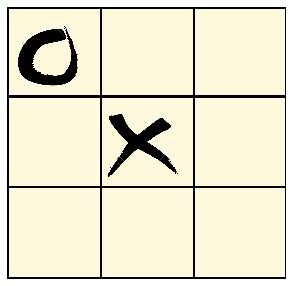

In [10]:
tri = Triqui()
s = tri.estado_inicial
s = tri.resultado(s, (1,1)) # Juega X
s = tri.resultado(s, (0,2)) # Juega O
if tri.player(s)==2:
    print('Le corresponde el turno a X')
elif tri.player(s)==1:
    print('Le corresponde el turno a O')   
tri.render(s)

<a class="anchor" id="ej3"></a>**Ejercicio 3:** 

([Anterior ejercicio](#ej2)) ([Próximo ejercicio](#ej4))

Adapte la función `minimax_search` para que la decisión que se tome sea sensible al jugador al que le corresponde el turno. De esta manera, si juegan las $X$, se busca maximizar el valor, pero si juegan las $O$, se busca minimizar el valor. Confirme la correctitud de su respuesta con el cuarto tablero de prueba:

In [15]:
def minimax_search(juego, estado):
    pass

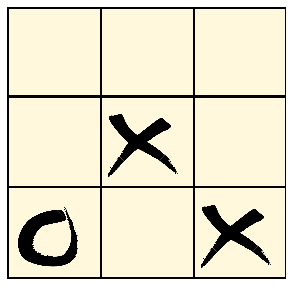

Computador juega en: (0, 2)


In [12]:
# Cuarto tablero de prueba
s1 = tri.resultado(tri.estado_inicial, (1,1)) # Juega X
s1 = tri.resultado(s1, (0,0)) # Juega O
s1 = tri.resultado(s1, (2,0)) # Juega X
tri.render(s1)
print("Computador juega en:", minimax_search(tri, s1)) 
# La respuesta debe ser (0, 2)

**Respuesta:**

In [11]:
def minimax_search(juego, estado):
    jugador = juego.player(estado)
    # Determina cuál jugador tiene el turno
    if jugador == 2: # Juegan las X (MAX)        
        valor, accion = max_value(juego, estado)
    else: # Juegan las O (MIN)
        valor, accion = min_value(juego, estado)
    return accion

---

## Implementando el engine <a class="anchor" id="engine"></a>

([Volver a minimax](#minimax))

¡Ya podemos jugar contra el computador! Intente ganarle al engine que acabamos de construir mediante el análisis minimax:

In [13]:
# Corra esta celda para comenzar un juego nuevo
tri = Triqui()
s = tri.estado_inicial

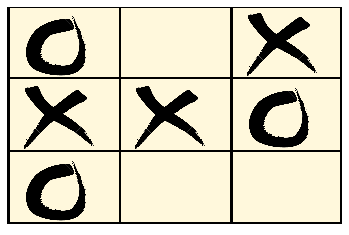

In [33]:
# Introduzca aquí su jugada, corra la celda y espere
# la jugada de O. Luego, vuelva a cambiar aquí mismo 
# su jugada y corra la celda de nuevo, etc.
a = (0,1)

assert(a in tri.acciones(s)), 'Acción no permitida. Intente de nuevo.'

###################
s = tri.resultado(s, a)
#clear_output(wait=True)
tri.render(s)
plt.show()

# Computador responde
if not tri.es_terminal(s):
    a = minimax_search(tri, s)
    s = tri.resultado(s, a)
    sleep(1)
    clear_output(wait=True)
    tri.render(s)
    plt.show()
    if tri.es_terminal(s):
        print('Juego terminado. ¡Gana O!')
else:
    jugador = tri.player(s)
    if tri.utilidad(s, jugador)==0:
        print('Juego terminado. ¡Empate!')
    else:
        print('Juego terminado. ¡Gana X!')

----

El algoritmo minimax realiza una exploración completa del espacio de estados mediante una metodología depth-first. Si la profundidad máxima del árbol fuera $m$ y en cada estado hubiera $b$ acciones posibles, entonces la complejidad de tiempo del algoritmo es $O(b^m)$. Como se están generando todos los hijos de cada nodo al mismo tiempo, la complejidad de espacio (memoria) es de $O(b^m)$.

La complejidad exponencial de este algoritmo lo hace ineficiente para muchos juegos complejos. Una manera de prevenir que el árbol de estados crezca tan rápido es dejando de explorar opciones que no parecen viables. Una de estas alternativas se llama el algoritmo de poda alfa-beta, que veremos a continuación.

---

## Algoritmo de poda alfa-beta <a class="anchor" id="alfa-beta"></a>

([Volver al inicio](#inicio))

Para explicar el funcionamiento de la poda alfa-beta consideremos un ejemplo más bien simple. Supongamos un juego que define el siguiente árbol, con la utilidad de los estados terminales ya puestos sobre la figura debajo de cada hoja, y los nombres de las acciones posibles etiquetando cada arista:

<img src="imagenes/alfa-beta.png" width="350px">

Este árbol lo hemos puesto para ilustrar el comportamiento del juego. No obstante, es muy importante observar que la idea del algoritmo es evitar tener que construir todo el árbol, deteniendo la exploración del mismo cuando sabemos que una acción no es conveniente para el jugador respectivo. Vamos a ver cómo se logra esto. 

La creación del árbol de confrontación se hace explorando los hijos de cada estado. Durante esta exploración se llevará un registro del valor máximo de las acciones hasta ahora. Este es el valor alfa. También se llevará un registro del valor mínimo (beta). Veamos en nuestro ejemplo para qué llevamos este registro de alfa (el funcionamiento de beta es análogo intercambiando jugadores). 

El algoritmo comienza a explorar el árbol primero en profundidad, inicializado con un valor de alfa de $-\infty$ y de beta de $\infty$. Estamos asumiendo que en la raíz (estado A) le corresponde el turno a MAX:

<img src="imagenes/alfa-beta-1.png" width="350px">

Una vez se obtiene el valor minimax para el primer hijo explorado (en este caso B), se puede asignar un valor a alfa (en este caso, 3):

<img src="imagenes/alfa-beta-2.png" width="350px">

Este valor de alfa se usa en la exploración del siguiente hijo, en este caso el estado C. Esto es, en la expansión de los hijos de C (subexpansiones) se utiliza el valor de alfa = 3. Aquí observamos que la primera subexpansión representa una utilidad de 2, que es inferior a alfa. Este es el criterio para detener la exploración de C.

<img src="imagenes/alfa-beta-3.png" width="350px">

La razón de esta detención debe ser clara. Para establecer el valor minimax del estado C, MIN buscará una opción con mínimo valor minimax. Este valor será menor o igual a 2. Esto permite deducir que en el estado A, MAX no tomará la acción que lo lleve al estado C, toda vez que el valor minimax de una acción ya explorada le reporta un mejor valor (a saber, la acción que lo lleva al estado B). Es por esto que no tiene sentido seguir explorando el estado C y toda esta rama puede podarse. 

### Pseudo código de la poda alfa-beta

El siguiente es el pseudo código para el algoritmo de poda alfa-beta:

<img src="imagenes/poda-alfa-beta.png" width="500px">

**Nota:** Los mismos errores que en el Minimax-search ocurren en este pseudocódigo.

<a class="anchor" id="ej4"></a>**Ejercicio 4:** 

([Anterior ejercicio](#ej3)) ([Próximo ejercicio](#ej5))

Implemente un código python `alpha_beta_search` con la poda alfa-beta y corra el algoritmo desde la raíz.

In [ ]:
from juegos import Triqui
import numpy as np

def alpha_beta_search(juego, estado):
    pass

def max_value_alfa_beta(juego, estado, alfa, beta):
    pass

def min_value_alfa_beta(juego, estado, alfa, beta):
    pass

In [35]:
%%time
tri = Triqui()
s = tri.estado_inicial
alpha_beta_search(tri, s)

CPU times: user 1.62 s, sys: 45.6 ms, total: 1.67 s
Wall time: 1.62 s


(0, 0)

**Respuesta:**

In [3]:
def alpha_beta_search(juego, estado):
    jugador = juego.player(estado)
    valor, accion = max_value_alfa_beta(juego, estado, alfa=-np.infty, beta=np.infty)
    return accion  

def max_value_alfa_beta(juego, estado, alfa, beta):
    if juego.es_terminal(estado):
        jugador = juego.player(estado)
        return juego.utilidad(estado, jugador), None
    v = -np.infty
    for a in juego.acciones(estado):
        v2, a2 = min_value_alfa_beta(juego, juego.resultado(estado, a), alfa, beta)
        if v2 > v:
            v = v2
            accion = a
            alfa = max(alfa, v)
        if v >= beta:
            return v, accion
    return v, accion

def min_value_alfa_beta(juego, estado, alfa, beta):
    if juego.es_terminal(estado):
        jugador = juego.player(estado)
        return juego.utilidad(estado, jugador), None
    v = np.infty
    for a in juego.acciones(estado):
        v2, a2 = max_value_alfa_beta(juego, juego.resultado(estado, a), alfa, beta)
        if v2 < v:
            v = v2
            accion = a
            beta = min(beta, v)
        if v <= alfa:
            return v, accion
    return v, accion

---

<a class="anchor" id="ej5"></a>**Ejercicio 5:** 

([Anterior ejercicio](#ej4)) ([Próximo ejercicio](#ej6))

Adapte la función `alpha_beta_search` para que la decisión que se tome sea sensible al jugador al que le corresponde el turno.

**Respuesta:**

In [4]:
def alpha_beta_search(juego, estado):
    jugador = juego.player(estado)
    # Determina cuál jugador tiene el turno
    if jugador == 2: # Juegan las X (MAX)        
        valor, accion = max_value_alfa_beta(juego, estado, alfa=-np.infty, beta=np.infty)
    else: # Juegan las O (MIN)
        valor, accion = min_value_alfa_beta(juego, estado, alfa=-np.infty, beta=np.infty)
    return accion

---

**Comparación de tiempos**

Vamos a revisar de manera empírica, mediante tiempos de CPU, qué tanto más eficiente es el algoritmo de poda alfa-beta respecto al algoritmo original minimax, para el caso que nos ocupa de implementar el triqui.

In [17]:
# Creamos la lista de funciones
funs = [
    lambda s: minimax_search(tri, s),
    lambda s: alpha_beta_search(tri, s),
]
# Creamos la lista de nombres de las funciones
nombres = [
    'Minmax', 
    'Alfa-Beta', 
]

# Inicializamos el juego
tri = Triqui()
s = tri.estado_inicial
# Definimos una lista fija de jugadas para ambas funciones
jugadas = [(0, 0), (1, 1), (0, 1)]
# Creamos una lista auxiliar de los datos por jugada
lista_dfs = []
# Iteramos por jugadas
for i, a in enumerate(jugadas):
    data = compara_funciones(
        lista_funs=funs, 
        lista_args=[[s], [s]], 
        lista_nombres=nombres, 
        num_it=5
    )
    data['No. de jugada'] = i
    lista_dfs.append(data)
    s = deepcopy(tri.resultado(s, a))
data = pd.concat(lista_dfs, ignore_index=True)

KeyboardInterrupt: 

In [ ]:
# Graficando
fig, ax = plt.subplots(1,1, figsize=(3*len(funs),3), tight_layout=True)
sns.lineplot(data=data, hue='Función', x='No. de jugada', y='tiempo_CPU', ax=ax)
ax.set_ylabel('Tiempo CPU para\ndecidir nueva jugada')
plt.savefig('minimax_vs_poda.png')

Podemos ver que, en este caso, la poda alfa-beta hace que la búsqueda de una decisión sea muy eficiente, comparada con la búsqueda del algoritmo minimax.

---

### Comparación de desempeño

Vamos a comparar el algoritmo contra un jugador que toma acciones de manera aleatoria. Primero veámos una presentación del agente de manera visual:

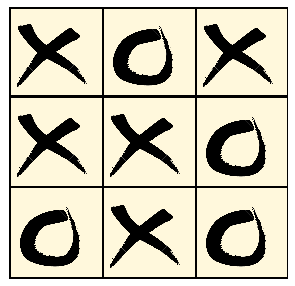

Juego terminado. ¡Empate!
None


In [5]:
# Inicialize game
tri = Triqui()
# Create other player
algorithm = lambda s: alpha_beta_search(tri, s)
other_player = PlfromAlgo(algorithm)
# Create environment
env = EnvfromGameAndPl2(tri, other_player)
# Create player
choices = list(product([0,1,2], repeat=2))
player_random = Random(choices=choices)
# Create episode
episodio = Episode(environment=env,\
        agent=player_random,\
        model_name='Random',\
        num_rounds=15)
# Visualize
#episodio.simulate(verbose=4)
episodio.sleep_time = 1
episodio.renderize()
s = episodio.environment.state
print(episodio.environment.game.give_result(s))

Aquí juegan un alfa-beta contra otro alfa-beta:

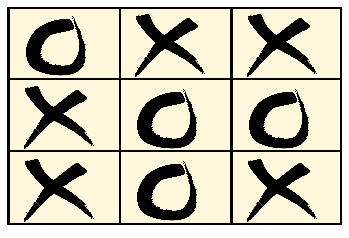

Juego terminado. ¡Empate!
None


In [166]:
# Inicialize game
tri = Triqui()
# Create players
algorithm = lambda s: alpha_beta_search(tri, s)
player_alpha_beta = PlfromAlgo(algorithm)
other_player = PlfromAlgo(algorithm)
# Create and load environment
env = EnvfromGameAndPl2(tri, other_player)
# Create episode
episodio = Episode(environment=env,\
        agent=player_alpha_beta,\
        model_name='alfa-beta',\
        num_rounds=15)
# Visualize
#episodio.simulate(verbose=4)
episodio.sleep_time = 1
episodio.renderize()
s = episodio.environment.state
print(episodio.environment.game.give_result(s))

Mediante el siguiente código vemos una comparación del desempeño del agente alfa-beta, jugando como segundo jugador (es decir, las "O" que juegan de segundo) contra un agente aleatorio y otro agente alfa-beta. Corremos un torneo con 10 episodios:

Testing agents over environment: 100%|██████████| 1/1 [00:23<00:00, 23.04s/it]


Average sum of rewards:
 model
Alfa-Beta    0.0
Random      -0.9
Name: reward, dtype: float64

Episode termination percentage:
 model
Alfa-Beta    100.0
Random       100.0
Name: done, dtype: float64


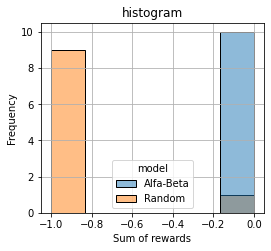

In [41]:
# Create experiment
exp = Experiment(num_rounds=300, \
                       num_episodes=10)
# Inicialize game
tri = Triqui()
# Set other player as alfa-beta
algorithm = lambda s: alpha_beta_search(tri, s)
other_player = PlfromAlgo(algorithm)
# Create and load environment
env = EnvfromGameAndPl2(tri, other_player)
exp.load_env(env, "triqui")
# Create players
# Random
choices = list(product([0,1,2], repeat=2))
player_random = Random(choices=choices)
# Alfa-Beta
player_alpha_beta = PlfromAlgo(algorithm)
# Run the experiment
agents_list = [player_random, player_alpha_beta]
names = ['Random', 'Alfa-Beta']
# Run the experiment
exp.run_experiment(agents=agents_list, \
                   names=names, \
                   measures=['histogram'])

Los resultados son los de esperar. El agente alfa-beta le gana la gran mayoría de las veces al random, pero siempre empata contra otro alfa-beta. En cualquier caso, el agoritmo alfa-beta nunca pierde.

## Funciones de evaluación <a class="anchor" id="feval"></a>

([Volver al inicio](#inicio))

Vamos a ver ahora un ejemplo muy bonito en el que se requiere usar funciones de evaluación para darle un valor a un estado dado. Observe que los dos algoritmos anteriores atribuyen valor minimax a los estados a partir de la utilidad de los estados terminales. Estos algoritmos toman esta utilidad y la 'suben' por los estados hasta la raíz. Pero, ¿qué pasa si es muy ineficiente llegar hasta el estado final para obtener una utilidad? Esto ocurre en el juego del ajedrez, en donde la explosión de estados es exponencial. Por ejemplo, expandir un tablero tres jugadas hacia adelante implica considerar alrededor de 726 millones de estados.

Para evitar tener que bajar hasta los estados terminales, se puede usar una función `is_cutoff(s)`, la cual utiliza un criterio de detención para la expansión de estados. Esta función reemplazará el criterio `es_terminal` en los algoritmos minimax y poda alfa-beta.

In [7]:
def is_cutoff(self, board, d):
    if self.es_terminal(board):
        return True
    elif d >= self.max_lim:
        return True
    else:
        return False

Cuando se 'dispara' la condición `is_cutoff` y el estado no es terminal, debemos retornar un valor. Este valor estará dado por una función de evaluación, el cual debe aproximar qué tan bueno es un estado. Si el estado es mejor para MAX, la función de evaluación debe retornar valores positivos grandes; si es mejor para MIN, debe retornar valores negativos grandes. Veamos esto en el ejemplo del ajedrez.

**Torre y rey contra rey solitario**

Uno de los finales que todo principiante en ajedrez debe aprender es el de hacer mate mediante torre y rey contra rey solitario. Hemos creado una implementación de este juego en la clase `ReyTorreRey` en el módulo `juegos` usando la librería [python-chess](https://python-chess.readthedocs.io/en/latest/). Note que las acciones usan la [notación algebráica estándar](https://es.wikipedia.org/wiki/Notaci%C3%B3n_algebraica).

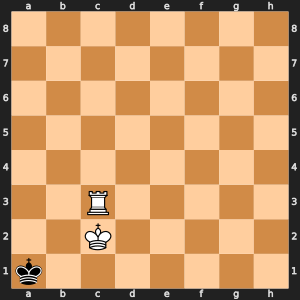

In [33]:
roo = ReyTorreRey(tablero_inicial=1)
s = roo.estado_inicial
roo.render(s)

En este tablero se puede hacer mate en una jugada. El mate se obtiene después de Ra3. Podemos incluir cada jugada de manera manual mediante el método `jugada_manual` en lugar de `resultado`:

Mate? True
Utilidad: 1000


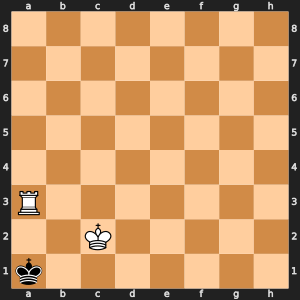

In [9]:
s = roo.jugada_manual(s, 'Ra3')
print('Mate?', roo.es_terminal(s))
print('Utilidad:', roo.utilidad(s, roo.player(s)))
roo.render(s)

Observe que, a pesar de que el mate está tan cerca en este estado, un árbol de confrontación tendrá que crear 16 nodos en el primer nivel, esto es, 12 jugadas posibles para la torre y 4 para el rey. El movimiento del rey contrincante genera menos nodos, a lo sumo 8, pero cada jugada adicional del blanco requerirá una cantidiad cercana a 18 nodos. Esta metodología, incluso con un alfa-beta, se quedará atascada en una progresión en la cual el rey blanco se va alejando cada vez más del rey negro. 

Para evitar este crecimiento del árbol en profundidad, usamos el criterio `is_cutoff`, junto con una función de evaluación para estimar una utilidad en el estado truncado.


### Agente con funciones de evaluación

Observe que el anterior tablero muestra tres condiciones indispensables para dar mate con torre y rey:

1. El rey blanco debe cortar los movimientos del rey negro.
2. El rey negro debe estar en uno de los bordes del tablero.
3. La torre debe atacar al rey sin poder ser comida por este.

La primera función de evaluación que consideraremos mide qué tan cerca a la oposición están los dos reyes. Cada vez que se alcance un cutoff en un estado `s`, la función de evaluación nos dará el valor máximo entre la distancia vertical y la horizontal de los reyes. Esto hará que el rey negro se lance como un chita contra el rey blanco.

Hemos implementado esta función en el agente `ChessFinalist1` del módulo `agents` y podemos visualizarlo mediante la clase `Episode` que ya conocíamos del primer notebook.

**Nota:** Observe que estamos creando un entorno uniendo el juego y un jugador automático como segundo jugador. Esto se hace mediante la clase `EnvfromGameAndPl2` del módulo `utils`.

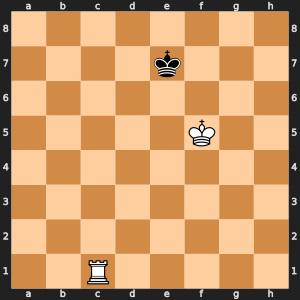

In [42]:
# Inicialize game
roo = ReyTorreRey(tablero_inicial=6)
# Create other player
other_player = ChessFinalist1(
    game=roo,
    jugador='negras', 
    pesos=[0,1,0,1],
    max_lim=3)
# Create environment
env = EnvfromGameAndPl2(roo, other_player)
# Create player
chess_player = ChessFinalist1(
    game=roo,
    jugador='blancas',
    max_lim=3,
    pesos=[1,0,0,0])
# Create episode
episodio = Episode(environment=env,\
        agent=chess_player,\
        model_name='Borde',\
        num_rounds=15)
# Visualize
# episodio.simulate(verbose=4)
episodio.sleep_time = 0.3
episodio.renderize()

El rey y la torre blancos no logran dar mate al rey negro. Este último se queda en el medio, pues eso es lo que le dice su función de evaluación: cuánto más estés en el centro, menor será el puntaje (las negras son "min"):

<img src="imagenes/rincon.png" width="300px">

Observe que `ChessFinalist1` tiene implementadas cuatro funciones de evaluación:

   1. Oposición: Que da un valor mayor cuanto más cerca estén los reyes de la oposición.
   2. Material: Que da un valor positivo a las piezas blancas y uno negativo a las piezas negras y devuelve la suma.
   3. Rectángulo: Sobre el cual volveremos más adelante.
   4. Rey negro en el borde: Que implementa la evaluación de la figura anterior, pasada por una función exponencial.
    
Es posible combinar las funciones de evaluación para obtener una evaluación unificada, que trata de tener en cuenta todos los factores anteriores. Estos valores pueden modificarse al inicializar el agente mediante el argumento `pesos`. Observe que el rey negro fue implementado con `pesos=[0,1,0,1]`, en el cual tomamos en cuenta quedarnos en el centro y capturar la torre enemiga si es posible. Tenga en cuenta también que los pesos no son binarios y pueden tomar valores reales.

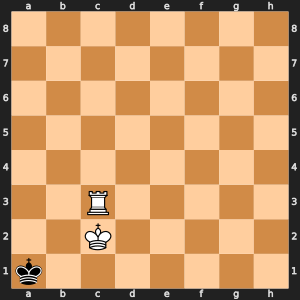

Evaluación del rey negro en el borde: 1


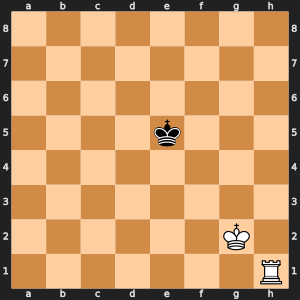

Evaluación del rey negro en el borde: -2


In [124]:
# Inicialize game
roo = ReyTorreRey(tablero_inicial=5)
# Create other player
other_player = ChessFinalist1(
    game=roo,
    jugador='negras', 
    pesos=[0,1,0,1],
    max_lim=3)
# Create boards for sanity check
roo = ReyTorreRey(tablero_inicial=1)
s = roo.estado_inicial
roo.render(s)
print("Evaluación del rey negro en el borde:", other_player._rey_borde(s))
#print("Valor en términos de la figura:", np.log(other_player._rey_borde(s)/10))
roo = ReyTorreRey(tablero_inicial=6)
s = roo.estado_inicial
roo.render(s)
print("Evaluación del rey negro en el borde:", other_player._rey_borde(s))
#print("Valor en términos de la figura:", np.log(other_player._rey_borde(s)/10))

**Rectángulo**

Para llevar al rey negro al borde, es necesario usar la torre. Podemos darle un mayor puntaje al estado de las blancas cuanto más arrinconado esté el rey negro por la torre blanca. El siguiente tablero muestra el valor de la función de evaluación que calcula el área disponible para el rey negro con base en la casilla en que se encuentra la torre blanca:

<img src="imagenes/rectangulo.png" width="350px">

<a class="anchor" id="ej6"></a>**Ejercicio 6:** 

([Anterior ejercicio](#ej5)) ([Próximo ejercicio](#ej7))

Implemente el método `_rectangulo` para calcular el área que rodea al rey negro permitida por la torre blanca.

In [47]:
def _rectangulo(self, estado):
    # Contamos el área del rectánguno creado por la torre
    # y que rodea al rey negro
    fila_torre_blanca, columna_torre_blanca = self._casilla_pieza(estado, 'R')
    fila_rey_negro, columna_rey_negro = self._casilla_pieza(estado, 'k')
    if columna_torre_blanca == columna_rey_negro:
        if columna_torre_blanca <= 4: 
            columna_torre_blanca -= 1
        else:
            columna_torre_blanca += 1
    if fila_torre_blanca == fila_rey_negro:
        if fila_torre_blanca <= 4: 
            fila_torre_blanca -= 1
        else:
            fila_torre_blanca += 1
    # AQUÍ SU CÓDIGO
    if fila_rey_negro < fila_torre_blanca:
        if columna_rey_negro < columna_torre_blanca:
            area = ...
        else:
            area = ...
    else:
        if columna_rey_negro < columna_torre_blanca:
            area = ...
        else:
            area = ...
    # HASTA AQUÍ SU CÓDIGO
    assert(area != 0), display(estado)
    return 64 / area


setattr(ChessFinalist1, '_rectangulo', _rectangulo)

In [123]:
from juegos import ReyTorreRey
from utils import *
from agents import *

%reload_ext autoreload
%autoreload 2

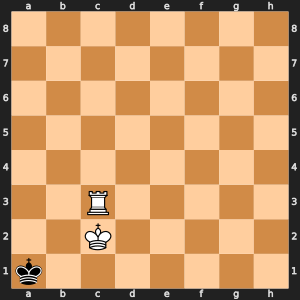

Área del rectángulo: 4.0


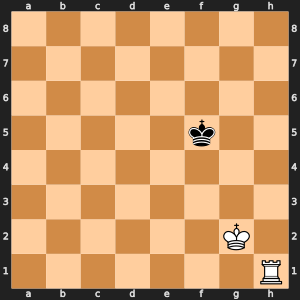

Área del rectángulo: 49.00000000000001


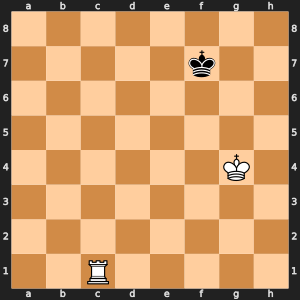

Área del rectángulo: 35.0


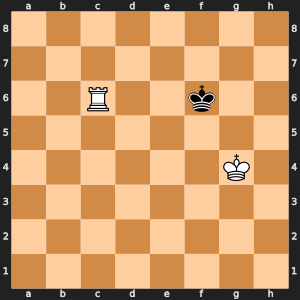

Área del rectángulo: 30.0


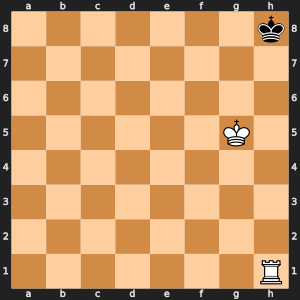

Área del rectángulo: 49.00000000000001
¡Tests superados!


In [94]:
# Create player
chess_player = ChessFinalist1(game=roo)
# Create game
roo = ReyTorreRey(tablero_inicial=1)
s = roo.estado_inicial
roo.render(s)
# Check board evaluation
evaluacion = 64 / chess_player._rectangulo(s)
print('Área del rectángulo:', evaluacion)
assert(np.isclose(evaluacion, 4))
# Create game
roo = ReyTorreRey(tablero_inicial=5)
s = roo.estado_inicial
roo.render(s)
# Check board evaluation
evaluacion = 64 / chess_player._rectangulo(s)
print('Área del rectángulo:', evaluacion)
assert(np.isclose(evaluacion, 49))
# Create game
roo = ReyTorreRey(tablero_inicial=7)
s = roo.estado_inicial
roo.render(s)
# Check board evaluation
evaluacion = 64 / chess_player._rectangulo(s)
print('Área del rectángulo:', evaluacion)
assert(np.isclose(evaluacion, 35))
# Create game
roo = ReyTorreRey(tablero_inicial=8)
s = roo.estado_inicial
roo.render(s)
# Check board evaluation
evaluacion = 64 / chess_player._rectangulo(s)
print('Área del rectángulo:', evaluacion)
assert(np.isclose(evaluacion, 30))
# Create game
roo = ReyTorreRey(tablero_inicial=9)
s = roo.estado_inicial
roo.render(s)
# Check board evaluation
evaluacion = 64 / chess_player._rectangulo(s)
print('Área del rectángulo:', evaluacion)
assert(np.isclose(evaluacion, 49))
print('¡Tests superados!')

**Respuesta:**

In [143]:
def _rectangulo(self, estado):
    # Contamos el área del rectánguno creado por la torre
    # y que rodea al rey negro
    fila_torre_blanca, columna_torre_blanca = self._casilla_pieza(estado, 'R')
    fila_rey_negro, columna_rey_negro = self._casilla_pieza(estado, 'k')
    if columna_torre_blanca == columna_rey_negro:
        if columna_torre_blanca <= 4: 
            columna_torre_blanca -= 1
        else:
            columna_torre_blanca += 1
    if fila_torre_blanca == fila_rey_negro:
        if fila_torre_blanca <= 4: 
            fila_torre_blanca -= 1
        else:
            fila_torre_blanca += 1
    if fila_rey_negro < fila_torre_blanca:
        if columna_rey_negro < columna_torre_blanca:
            area = np.clip(fila_torre_blanca, 1, 7) * np.clip(columna_torre_blanca, 1, 7)
        else:
            area = np.clip(fila_torre_blanca, 1, 7) * np.clip(7 - columna_torre_blanca, 1, 7)
    else:
        if columna_rey_negro < columna_torre_blanca:
            area = np.clip(7 - fila_torre_blanca, 1, 7) * np.clip(columna_torre_blanca, 1, 7)
        else:
            area = np.clip(7 - fila_torre_blanca, 1, 7) * np.clip(7 - columna_torre_blanca, 1, 7)
    assert(area != 0), display(estado)
    return 64 / area


setattr(ChessFinalist1, '_rectangulo', _rectangulo)

---

Veamos al rey y torre blancos acorralar al rey negro y darle jaque mate:

In [148]:
from juegos import ReyTorreRey
from utils import *
from agents import *

%reload_ext autoreload
%autoreload 2

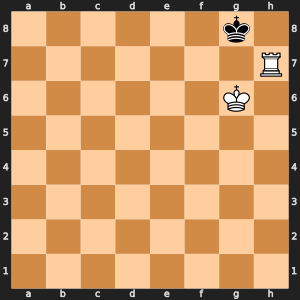

In [160]:
# Inicialize game
roo = ReyTorreRey(tablero_inicial=5)
# Create other player
other_player = ChessFinalist1(
    game=roo,
    jugador='negras', 
    pesos=[0,1,0,1],
    max_lim=2)
#other_player.debug = True
# Create environment
env = EnvfromGameAndPl2(roo, other_player)
# Create player
chess_player = ChessFinalist1(
    game=roo,
    jugador='blancas',
    max_lim=2,
    pesos=[1,1,1,1])
#chess_player.debug = True
# Create episode
episodio = Episode(environment=env,\
        agent=chess_player,\
        model_name='Borde',\
        num_rounds=50)
# Visualize
#episodio.simulate(verbose=4)
episodio.sleep_time = 0.1
episodio.renderize()
#s = episodio.environment.state
#print(episodio.environment.game.give_result(s))

Testing agents over environment: 100%|█████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


Average sum of rewards:
 model
ChessFinalist    200.0
Name: reward, dtype: float64

Episode termination percentage:
 model
ChessFinalist    20.0
Name: done, dtype: float64


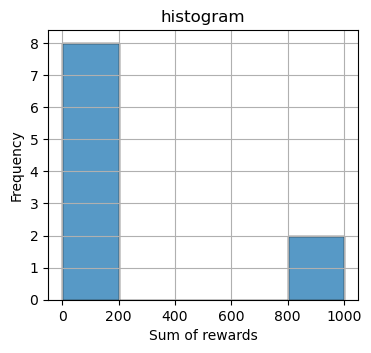

In [161]:
# Create experiment
exp = Experiment(num_rounds=20, \
                 num_episodes=1)
# Create other player
other_player = ChessFinalist1(
    game=roo,
    jugador='negras', 
    pesos=[0,1,0,1],
    max_lim=3)
# Load test suite
exp.load_game_test_suite(other_player, "test_suite_rey_torre_rey.json")
exp.test_suite = exp.test_suite[:10]
# Create list of agents
chess_player = ChessFinalist1(
    game=roo,
    jugador='blancas',
    max_lim=3,
    pesos=[1,1,1,1])
agents_list = [chess_player]
names = ['ChessFinalist']
# Run the experiment
exp.run_experiment(agents=agents_list, \
                   names=names, \
                   measures=['histogram'])

Vemos que el agente logra dar mate dos de cada 10 veces cuando damos un máximo de quince jugadas. Aún hay espacio para mejorar.

## Monte Carlo Tree Search <a class="anchor" id="mcts"></a>

([Volver al inicio](#inicio))

Hay juegos para los cuales resulta difícil definir una función de evaluación que permitan un desempeño óptimo del agente. O bien porque no se cuenta con suficiente información de experto o bien porque el problema es reclacitrante a los intentos más sensatos de crear una buena función de evaluación. En estas situaciones, se ha encontrado muy útil hacer una exploración aleatoria de las opciones de juego en un tablero, de tal manera que la evaluación del tablero se obtiene a partir de la utilidad promedio de los resultados obtenidos de la exploración. Esta estrategia ha sido llamada Búsqueda Pura Monte Carlo. Más aún, se ha creado un algoritmo, llamado Búsqueda de Árboles Monte Carlo, el cual trate de tomar ventaja de las acciones más promisorias mediante la extensión progresiva de un árbol de búsqueda. Los recursos computacionales se invierten en su mayoría a aprovechar los nodos más prometedores, y solo un poco en la exploración. 

Los componentes de este algoritmo son:

1. Selección
2. Expansión
3. Simulación
4. Backup de valores

Veremos a continuación los componentes de esta estrategia, aplicada al ejemplo del Rey y Torre contra Rey solitario.

### Simulación de juego <a class="anchor" id="sim"></a>

([Volver a Monte Carlo Tree Search](#mcts))


Comenzaremos con las simulaciones. Para hacer una simulación, el computador toma el tablero y selecciona una jugada posible para el jugador correspondiente, luego obtiene el tablero resultado y selecciona una jugada posible para el otro jugador, y así hasta terminar el juego. Observe que proceder de esta manera es construir un camino desde el tablero inicial hasta un estado terminal. En esta simulación no se expande un árbol, pues no se consideran todas las opciones de juego en cada paso; solamente consideramos una. En otras palabras, sólo se abre una rama del árbol (el cual es inexistente).

La selección de jugadas puede hacerse de manera aleatoria, o puede utilizarse para ello una 'política de juego' o 'rollout policy', si se dispone de esta información. 

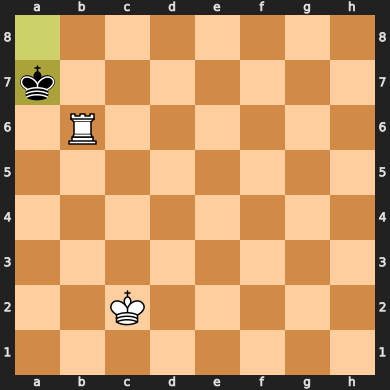

{'blancas': 0, 'negras': 1}

In [239]:
# Inicialize game
roo = ReyTorreRey(tablero_inicial=4)
# Create player
player = ChessFinalist2(
    game=roo,
    jugador='blancas', 
    max_lim=2,
    sim_lim=20
)
s = roo.estado_inicial
player.debug = False
player.simulate_game(s, render=True)

### Selección de nodos <a class="anchor" id="seleccion"></a>

([Volver a Monte Carlo Tree Search](#mcts))

Recordemos que nuestro objetivo es ranquear las jugadas posibles dado un tablero. Para realizar esto, vamos a buscar jugadas que frecuentemente llevan a la victoria. Observe que estamos en una situación en donde no tenemos recursos computacionales para explorar todas las jugadas posibles. Así pues, nuestra exploración cubrirá sólo una porción pequeña del árbol de confrontación. Si esta exploración se hace de manera completamente aleatoria, la información resultante usualmente no resulta muy útil. Más bien, la idea es realizar la exploración de manera que se exploten las jugadas más prometedoras que se vayan encontrado, de tal manera que tengamos más evidencia sobre ellas. Para ello se tratará de balancear el dilema entre explorar nuevas opciones y explotar aquellas más prometedoras.

Para guiar este proceso usaremos una estructura de árbol, en el cual cada nodo guarda un tablero y la utilidad obtenida hasta ahora por el jugador respectivo. La utilidad la obtenemos mediante la simulación que implementamos en la sección anterior. La idea es ir expandiendo los nodos más prometedores, es decir, aquellos en donde las simulaciones han mostrado mayor utilidad para el jugador respectivo. De esta manera, los recursos computacionales se enfocan en pocas combinaciones de jugadas, que se exploran más frecuentemente que otras menos prometedoras.

Nuestra estructura de nodos, que es una estructura recursiva basada en nodos con los siguientes atributos:

* **estado**: el tablero correspondiente al nodo.
* **madre**: el nodo del que proviene.
* **accion**: acción usada para obtener el nodo en cuestión desde su nodo madre.
* **Valor**: guarda la información de la recompensa obtenida desde alguno de los sucesores del nodo, sobre el total de la exploración.

La siguiente es una posible implementación de esta estructura en python:

In [240]:
# Inicialize game
roo = ReyTorreRey(tablero_inicial=1)
# Create player
player = ChessFinalist2(
    game=roo,
    jugador='blancas', 
    max_lim=2,
    sim_lim=20,
    time_lim=20,
    beam_width=10,
)
s = roo.estado_inicial
arbol = ArbolBusquedaJuego(s, \
                           juego=player.game, \
                           rollout_policy=player.play_policy, \
                           sim_lim=50, \
                           beam_width=2, \
                           ucb_constant=2,
                                )
n = arbol.raiz
print(n)

Estado:--raiz--
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . R . . . . .
. . K . . . . .
k . . . . . . .
Profundidad: 0



In [241]:
nodo = arbol.seleccionar_ucb()
print(nodo)

Estado:
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . R . . . . .
. . . . . . . .
. . . . . . . .
k . K . . . . .
. . . . . . . .
Profundidad: 1
Proviene de:
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . R . . . . .
. . K . . . . .
k . . . . . . .
Mediante acción: Rc5
Valor: 0/0



**Upper confidence bound formula**

Sea $n$ un nodo y suponga que 

* $U(n)$ es la utilidad acumulada de las simulaciones desde $n$ o uno de sus descendientes.
* $N(n)$ es el número total de simulaciones realizadas desde $n$ o uno de sus descendientes.
* $C$ es la constante que permite balancear la exploración vs la explotación.

Entonces la fórmula de cota de confianza superior (UCB1) es la siguiente:

$$UCB1(n)=\frac{U(n)}{N(n)} + C\sqrt{\frac{\log(N(n.madre))}{N(n)}}$$

El término de la izquierda es el promedio de la utilidad, que en nuestro caso se reduce a la frecuencia relativa de victorias. El término de la derecha representa una relación entre exploración y explotación. Es inversamente proporcional a la cantidad de veces que $n$ ha sido explorado y directamente proporcional a la cantidad de veces que $n.madre$ ha sido explorado. Es importante notar que el denominador de este término crece mucho más rápido que su numerador, así que el término tenderá hacia cero a medida que $N(n)$ crezca. Esto es, el término de la derecha tiende a desaparecer a medida que el nodo $n$ es explorado más veces.

Esta fórmula puede entenderse también de la siguiente manera. Si $n$ no ha sido explorado muchas veces, el valor de $UCB1(n)$ tiende a ser igual a $C$. Para nodos que han sido explorados muchas veces, el valor de $UCB1(n)$ tiende a ser igual a la utilidad promedio de $n$ (es decir, $\frac{U(n)}{N(n)}$).  

In [83]:
print("Valor de UCB para un nodo poco explorado:")
n = 1
m = 100
ucb_constant = 2
print(ucb_constant * np.sqrt(np.log(m) / n))

Valor de UCB para un nodo poco explorado:
4.291932052578694


In [84]:
ucb_constant = 2
# Nodo cada vez más explorado:
for n in range(1, 1000, 10):
    clear_output(wait=True)
    m = 5*n
    print("Valor de UCB a medida que el nodo se explora más veces:")
    print(ucb_constant * np.sqrt(np.log(m) / n))
    sleep(.1)

Valor de UCB a medida que el nodo se explora más veces:
0.18531509639427907


### Expansión del árbol <a class="anchor" id="expansion"></a>

([Volver a Monte Carlo Tree Search](#mcts))

### Back-up del valor <a class="anchor" id="back-up"></a>

([Volver a Monte Carlo Tree Search](#mcts))

In [242]:
# Inicialize game
roo = ReyTorreRey(tablero_inicial=1)
# Create player
player = ChessFinalist2(
    game=roo,
    jugador='blancas', 
    max_lim=2,
    sim_lim=20,
    time_lim=20,
    beam_width=10,
)
s = roo.estado_inicial
player.states.append(s)
player.show_tree = True
player.program()

accion --> valor
	c3c5 --> 1/10
	c2b3 --> 1/2
	c3f3 --> 0/1
	c2d3 --> 0/1
	c3c7 --> 1/2
	c2d2 --> 0/1
	c3c6 --> 2/2
	c3g3 --> 0/1
	c3d3 --> 0/1
	c3h3 --> 0/1


Acción seleccionada: c3c6


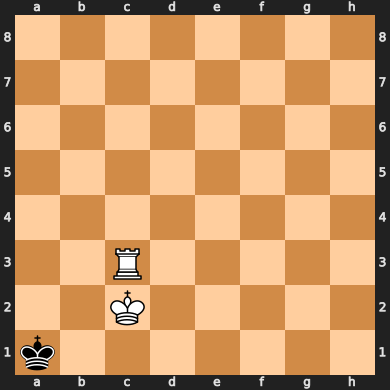

In [243]:
print('Acción seleccionada:', player.plan[0])
display(s)

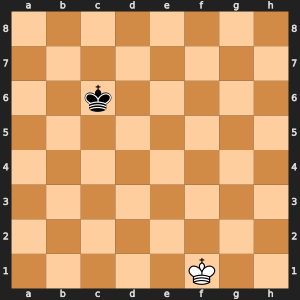

In [244]:
# Inicialize game
roo = ReyTorreRey(tablero_inicial=5)
# Create other player
other_player = ChessFinalist1(
    game=roo,
    jugador='negras', 
    pesos=[0,1,0,1],
    max_lim=2)
#other_player.debug = True
# Create environment
env = EnvfromGameAndPl2(roo, other_player)
# Create player
chess_player = ChessFinalist2(
    game=roo,
    jugador='blancas', 
    max_lim=2,
    sim_lim=10,
    time_lim=20,
    beam_width=7,
)
#chess_player.debug = True
# Create episode
episodio = Episode(environment=env,\
        agent=chess_player,\
        model_name='Borde',\
        num_rounds=10)
# Visualize
#episodio.simulate(verbose=4)
episodio.sleep_time = 0.1
episodio.renderize()
#s = episodio.environment.state
#print(episodio.environment.game.give_result(s))

## En este notebook usted aprendió 

([Volver al inicio](#inicio))

* El algoritmo minimax para la toma de decisiones perfecta en un juego competitivo de 2 jugadores.
* El algoritmo de poda alfa beta para eliminar porciones del árbol de confrontación que no influyen en la toma de decisiones.
* Funciones de evaluación para aproximar qué tan buena es una posición para cada jugador.